# Example 7 - Folded Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 4016 m wide (W-E extent) and 2790 m high (N-S extent). The model represents folded layers (blue to light green) above a basement unit (light blue). The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example07.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example07/'
gg.download_gemgis_data.download_tutorial_data(filename="example07_folded_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example07.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo7.shp')
topo.head()

,id,Z,geometry
0,None,1400,"LINESTRING (3.284 251.204, 70.568 216.700, 129..."
1,None,1300,"LINESTRING (1.559 681.649, 61.079 639.381, 127..."
2,None,1200,"LINESTRING (4.146 1199.219, 94.721 1109.507, 1..."
3,None,1300,"LINESTRING (4.578 2374.964, 84.370 2414.213, 1..."
4,None,1200,"LINESTRING (4.146 2108.847, 71.430 2114.885, 1..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=10)

### Plotting the raster

Text(61.66664224872254, 0.5, 'Y [m]')

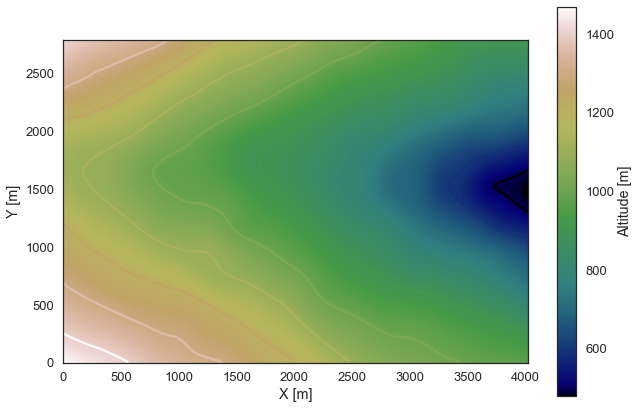

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1)
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,4016,0,2790], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster7.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example07.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces7.shp')
interfaces.head()

,id,formation,geometry
0,None,H,"LINESTRING (2701.546 2406.881, 2753.302 2392.2..."
1,None,G,"LINESTRING (3160.457 2785.569, 3226.878 2673.4..."
2,None,G,"LINESTRING (2905.123 4.496, 2965.506 125.262, ..."
3,None,F,"LINESTRING (3239.818 2.771, 3292.437 100.246, ..."
4,None,E,"LINESTRING (3896.268 2.771, 3938.536 86.445, 3..."


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords.head()

,formation,geometry,X,Y,Z
0,H,POINT (2701.546 2406.881),2701.55,2406.88,911.61
17,H,POINT (2731.737 712.704),2731.74,712.70,904.72
1,H,POINT (2753.302 2392.216),2753.30,2392.22,904.77
31,H,POINT (2683.431 2403.430),2683.43,2403.43,913.30
29,H,POINT (2663.590 2327.520),2663.59,2327.52,895.20


### Plotting the Interface Points

Text(62.08430654900204, 0.5, 'Y [m]')

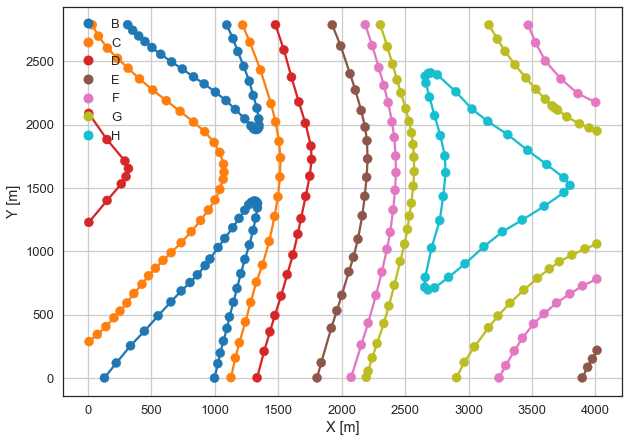

In [10]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example07.png" width="800">

In [11]:
strikes = gpd.read_file(file_path + 'strikes7.shp')
strikes.head()

,id,formation,Z,geometry
0,1,H,500,"LINESTRING (3775.502 1556.773, 3777.227 1482.157)"
1,2,H,600,"LINESTRING (3536.557 1741.804, 3533.970 1312.221)"
2,3,H,700,"LINESTRING (3281.223 1939.343, 3278.635 1159.538)"
3,4,H,800,"LINESTRING (3034.515 2115.317, 3025.026 947.335)"
4,2,H1,900,"LINESTRING (2660.140 2341.322, 2657.552 791.202)"


### Calculate Orientations for each formation

In [12]:
orientations_b = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B'].sort_values(by='Z', ascending=True).reset_index())
orientations_b

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,48.08,90.40,1050.00,POINT (1289.120 1684.656),1.00,B,1289.12,1684.66
1,44.77,90.25,1150.00,POINT (1191.860 1645.299),1.00,B,1191.86,1645.30
2,45.45,90.15,1250.00,POINT (1090.395 1549.117),1.00,B,1090.40,1549.12


In [13]:
orientations_b1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B1'].sort_values(by='Z', ascending=True).reset_index())
orientations_b1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.67,90.24,1050.00,POINT (1131.154 1653.170),1.00,B1,1131.15,1653.17
1,22.38,90.19,1150.00,POINT (879.917 1593.218),1.00,B1,879.92,1593.22
2,21.07,90.17,1250.00,POINT (625.877 1541.677),1.00,B1,625.88,1541.68
3,22.22,90.21,1350.00,POINT (372.268 1490.136),1.00,B1,372.27,1490.14


In [14]:
orientations_c = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='C'].sort_values(by='Z', ascending=True).reset_index())
orientations_c

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,44.89,90.05,1050.00,POINT (1400.182 1647.671),1.00,C,1400.18,1647.67
1,46.27,89.68,1150.00,POINT (1298.016 1630.742),1.00,C,1298.02,1630.74
2,45.82,89.73,1250.00,POINT (1194.502 1529.169),1.00,C,1194.50,1529.17


In [15]:
orientations_c1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='C1'].sort_values(by='Z', ascending=True).reset_index())
orientations_c1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.00,90.03,1050.00,POINT (880.887 1605.834),1.00,C1,880.89,1605.83
1,21.02,90.00,1150.00,POINT (625.984 1571.006),1.00,C1,625.98,1571.01
2,22.47,90.04,1250.00,POINT (373.777 1535.531),1.00,C1,373.78,1535.53


In [16]:
orientations_d = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='D'].sort_values(by='Z', ascending=True).reset_index())
orientations_d

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,43.21,90.59,950.00,POINT (1694.388 1687.459),1.00,D,1694.39,1687.46
1,47.09,90.51,1050.00,POINT (1593.246 1635.810),1.00,D,1593.25,1635.81
2,46.90,90.42,1150.00,POINT (1498.520 1611.873),1.00,D,1498.52,1611.87
3,43.42,90.28,1250.00,POINT (1395.761 1496.605),1.00,D,1395.76,1496.61


In [17]:
orientations_d1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='D1'].sort_values(by='Z', ascending=True).reset_index())
orientations_d1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.43,90.07,1150.00,POINT (124.913 1649.935),1.00,D1,124.91,1649.94


In [18]:
orientations_e = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='E'].sort_values(by='Z', ascending=True).reset_index())
orientations_e

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,43.76,90.34,950.00,POINT (2099.332 1639.422),1.00,E,2099.33,1639.42
1,45.01,90.27,1050.00,POINT (1996.034 1608.314),1.00,E,1996.03,1608.31
2,43.87,90.13,1150.00,POINT (1891.549 1524.425),1.00,E,1891.55,1524.42


In [19]:
orientations_f = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='F'].sort_values(by='Z', ascending=True).reset_index())
orientations_f

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.87,90.06,750.00,POINT (3892.926 1329.042),1.00,F,3892.93,1329.04
1,22.62,90.02,850.00,POINT (3652.148 1342.844),1.00,F,3652.15,1342.84
2,21.94,90.16,950.00,POINT (3404.146 1346.510),1.00,F,3404.15,1346.51


In [20]:
orientations_f1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='F1'].sort_values(by='Z', ascending=True).reset_index())
orientations_f1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,45.08,90.35,950.00,POINT (2303.988 1581.088),1.00,F1,2303.99,1581.09
1,47.80,90.16,1050.00,POINT (2203.061 1538.981),1.00,F1,2203.06,1538.98


In [21]:
orientations_g = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='G'].sort_values(by='Z', ascending=True).reset_index())
orientations_g

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,23.14,89.99,650.00,POINT (3893.249 1475.040),1.00,G,3893.25,1475.04
1,22.18,90.01,750.00,POINT (3652.148 1500.919),1.00,G,3652.15,1500.92
2,22.32,89.97,850.00,POINT (3405.979 1548.255),1.00,G,3405.98,1548.25
3,22.15,90.18,950.00,POINT (3156.252 1530.894),1.00,G,3156.25,1530.89


In [22]:
orientations_g1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='G1'].sort_values(by='Z', ascending=True).reset_index())
orientations_g1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,47.83,90.14,850.00,POINT (2507.888 1600.335),1.00,G1,2507.89,1600.34
1,44.48,90.31,950.00,POINT (2406.315 1571.006),1.00,G1,2406.32,1571.01
2,46.29,90.39,1050.00,POINT (2303.880 1516.014),1.00,G1,2303.88,1516.01


In [23]:
orientations_h = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='H'].sort_values(by='Z', ascending=True).reset_index())
orientations_h

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.62,90.30,550.00,POINT (3655.814 1523.239),1.00,H,3655.81,1523.24
1,21.43,90.23,650.00,POINT (3407.596 1538.227),1.00,H,3407.60,1538.23
2,21.95,90.38,750.00,POINT (3154.850 1540.383),1.00,H,3154.85,1540.38


In [24]:
orientations_h1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='H1'].sort_values(by='Z', ascending=True).reset_index())
orientations_h1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,42.80,90.12,850.00,POINT (2713.191 1576.829),1.00,H1,2713.19,1576.83


### Merging Orientations

In [25]:
import pandas as pd
orientations = pd.concat([orientations_b, orientations_b1, orientations_c, orientations_c1, orientations_d, orientations_d1, orientations_e, orientations_f, orientations_f1, orientations_g, orientations_g1, orientations_h, orientations_h1]).reset_index()
orientations['formation'] = ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D',
 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'H', 'H', 'H', 'H']
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,48.08,90.40,1050.00,POINT (1289.120 1684.656),1.00,B,1289.12,1684.66
1,1,44.77,90.25,1150.00,POINT (1191.860 1645.299),1.00,B,1191.86,1645.30
2,2,45.45,90.15,1250.00,POINT (1090.395 1549.117),1.00,B,1090.40,1549.12
3,0,21.67,90.24,1050.00,POINT (1131.154 1653.170),1.00,B,1131.15,1653.17
4,1,22.38,90.19,1150.00,POINT (879.917 1593.218),1.00,B,879.92,1593.22


### Plotting the Orientations

Text(62.08430654900204, 0.5, 'Y [m]')

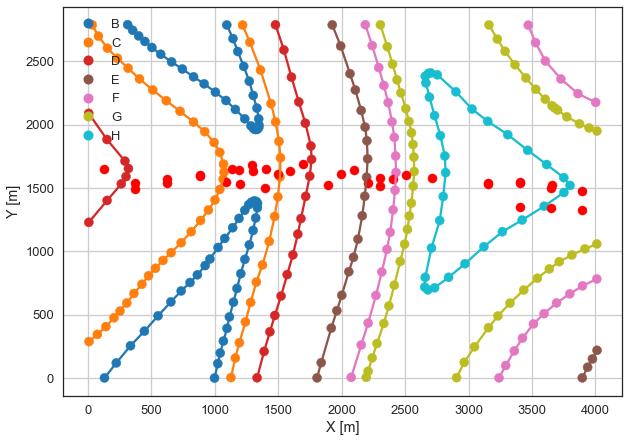

In [26]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [27]:
 import gempy as gp

### Creating new Model

In [28]:
geo_model = gp.create_model('Model7')
geo_model

Model7  2021-03-29 18:29

### Initiate Data

In [29]:
gp.init_data(geo_model, [0,4016,0,2790,-250,1500], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model7  2021-03-29 18:29

### Model Surfaces

In [30]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,H,Default series,1,#015482,1
1,G,Default series,2,#9f0052,2
2,F,Default series,3,#ffbe00,3
3,E,Default series,4,#728f02,4
4,D,Default series,5,#443988,5
5,C,Default series,6,#ff3f20,6
6,B,Default series,7,#5DA629,7


### Mapping the Stack to Surfaces

In [31]:
gp.map_stack_to_surfaces(geo_model,
                         {
                            
                          'Strata1': ('H','G','F','E','D','C','B')
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('A')

,surface,series,order_surfaces,color,id
0,H,Strata1,1,#015482,1
1,G,Strata1,2,#9f0052,2
2,F,Strata1,3,#ffbe00,3
3,E,Strata1,4,#728f02,4
4,D,Strata1,5,#443988,5
5,C,Strata1,6,#ff3f20,6
6,B,Strata1,7,#5DA629,7
7,A,Strata1,8,#4878d0,8


### Showing the Number of Data Points

In [32]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,H,Strata1,1,#015482,1,32,4
1,G,Strata1,2,#9f0052,2,51,7
2,F,Strata1,3,#ffbe00,3,34,5
3,E,Strata1,4,#728f02,4,23,3
4,D,Strata1,5,#443988,5,26,5
5,C,Strata1,6,#ff3f20,6,52,6
6,B,Strata1,7,#5DA629,7,64,7
7,A,Strata1,8,#4878d0,8,0,0


### Loading Digital Elevation Model

In [33]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster7.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  20.08      ,   13.95      , -241.25      ],
       [  20.08      ,   13.95      , -223.75      ],
       [  20.08      ,   13.95      , -206.25      ],
       ...,
       [4011.00497512, 2765.        ,  898.98010254],
       [4011.00497512, 2775.        ,  902.10076904],
       [4011.00497512, 2785.        ,  905.22875977]])

### Plotting Input Data

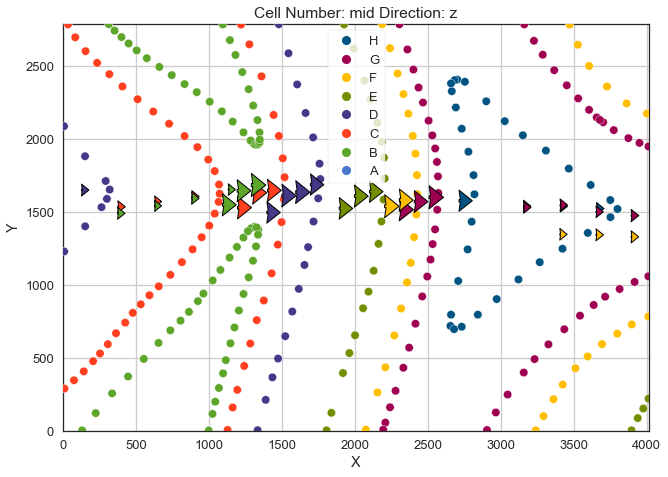

In [34]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

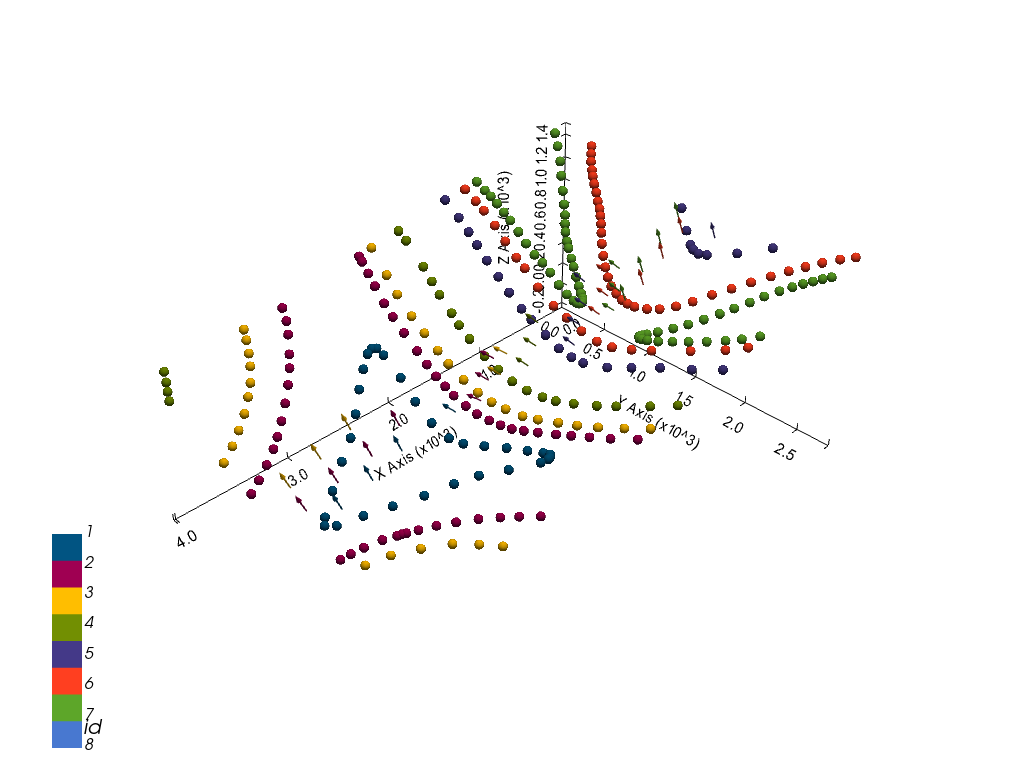

In [35]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [36]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             5193.73
$C_o$           642258.48
drift equations       [3]


### Computing Model

In [37]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

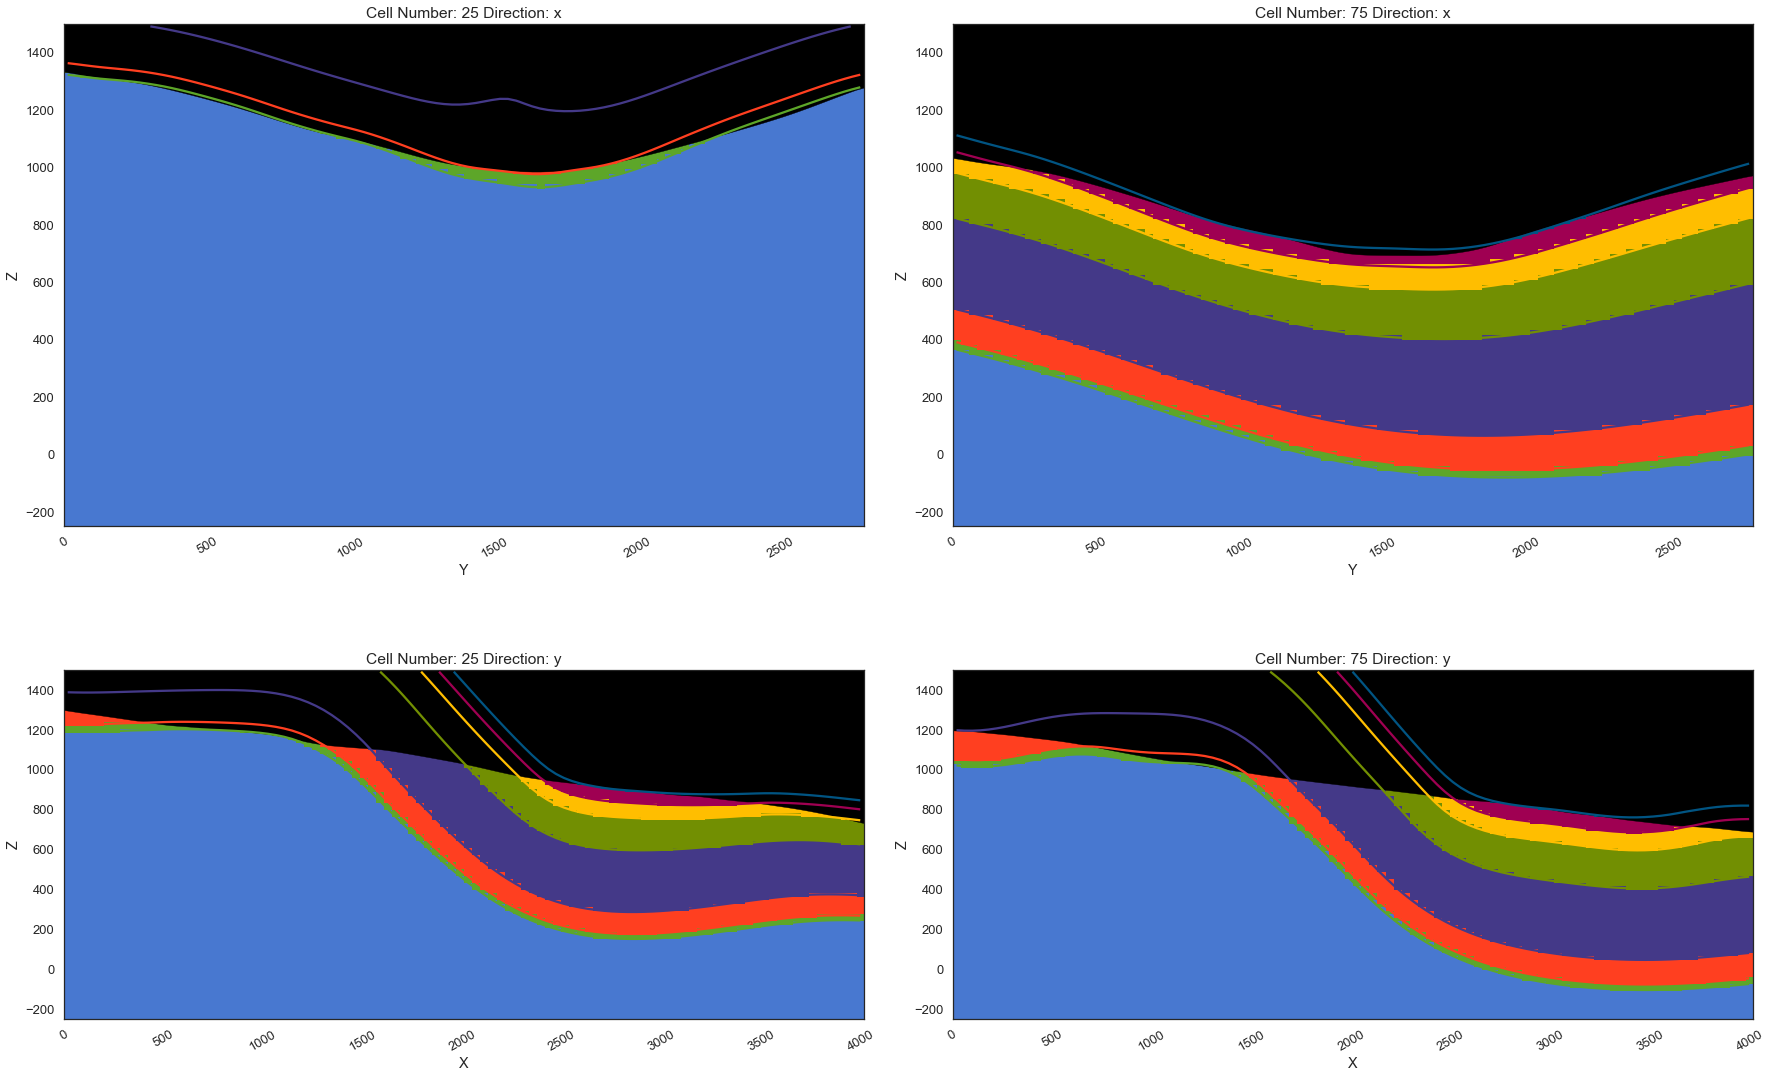

In [38]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

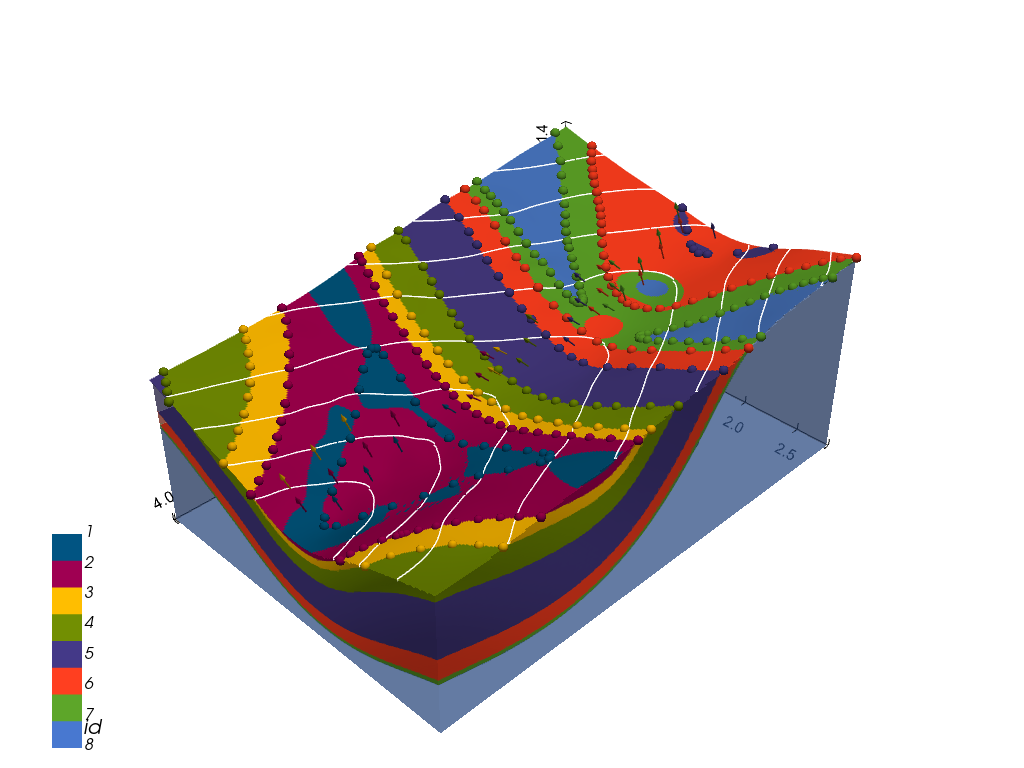

In [39]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)